# HW2 - Analysis 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection._search import ParameterGrid
import seaborn as sns
import copy

In [2]:
%matplotlib inline

In [5]:
from whatif import Model
from whatif import get_sim_results_df

### Base Model

This works - so there must be some reason self.demand needs () in the formula and the __init__ variables do not (in the demand and profit formulas) - 
Found online: self.demand() is called with parentheses because it's invoking a method of the class instance (self). If demand were an attribute rather than a method, you would access it without parentheses, as in self.demand.

In [203]:
class SingleProductSPF(Model):
    def __init__(self, fixed_cost=5000, var_cost=100, selling_price=0,
                 spf_constant=4900, spf_linear=-35, spf_quadratic=0.06):
        self.fixed_cost = fixed_cost
        self.var_cost = var_cost
        self.selling_price = selling_price
        self.spf_constant = spf_constant
        self.spf_linear = spf_linear
        self.spf_quadratic = spf_quadratic
        
    def demand(self):
        """Compute demand"""
        demand = (self.spf_quadratic * (self.selling_price ** 2)) + (self.spf_linear * self.selling_price) + self.spf_constant
        return demand
    
    def profit(self):
        """Compute profit"""
        profit = (self.demand() * self.selling_price) - (self.demand() * self.var_cost) - self.fixed_cost
        return profit
    
    def total_cost(self):
        """Computer total cost"""
        total_cost = (self.demand() * self.var_cost) - self.fixed_cost
        return total_cost


In [205]:
# Create a dictionary of base input values

base_inputs = {'selling_price': 115}

In [207]:
# Create a new model with default input values (0's)
model_test = SingleProductSPF()
print(model_test)
model_test.demand()

{'fixed_cost': 5000, 'var_cost': 100, 'selling_price': 0, 'spf_constant': 4900, 'spf_linear': -35, 'spf_quadratic': 0.06}


4900.0

In [209]:
# Update model with base inputs
model_test.update(base_inputs)
print(model_test)

{'fixed_cost': 5000, 'var_cost': 100, 'selling_price': 115, 'spf_constant': 4900, 'spf_linear': -35, 'spf_quadratic': 0.06}


In [211]:
model_test.demand()

1668.5

In [213]:
model_test.profit()

20027.5

### Data Table Function

In [216]:
def data_table(model, scenario_inputs, outputs):
    '''Create n-inputs by m-outputs data table.

    Parameters
    ----------
    model : object
        User defined object containing the appropriate methods and properties for computing outputs from inputs
    scenario_inputs : dict of str to sequence
        Keys are input variable names and values are sequence of values for each scenario for this variable. Is consumed by
        scikit-learn ParameterGrid() function. See https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html
    outputs : list of str
        List of output variable names

    Returns
    -------
    results_df : pandas DataFrame
        Contains values of all outputs for every combination of scenario inputs
    '''
    
    # Clone the model using deepcopy
    model_clone = copy.deepcopy(model)
    
    # Create parameter grid
    dt_param_grid = list(ParameterGrid(scenario_inputs))
    
    # Create the table as a list of dictionaries
    results = []

    # Loop over the scenarios
    for params in dt_param_grid:
        # Update the model clone with scenario specific values
        model_clone.update(params)
        # Create a result dictionary based on a copy of the scenario inputs
        result = copy.copy(params)
        # Loop over the list of requested outputs
        for output in outputs:
            # Compute the output.
            out_val = getattr(model_clone, output)()
            # Add the output to the result dictionary
            result[output] = out_val
        
        # Append the result dictionary to the results list
        results.append(result)

    # Convert the results list (of dictionaries) to a pandas DataFrame and return it
    results_df = pd.DataFrame(results)
    return results_df

### 1-Way Data Table

In [218]:
# Specify input ranges for scenarios (dictionary)
dt_param_ranges = {'selling_price': np.arange(80, 141, 10)}

# Specify desired outputs (list)
outputs = ['profit', 'demand']

# Use data_table function
mt_dt1_df = data_table(model_test, dt_param_ranges, outputs)
mt_dt1_df

,selling_price,profit,demand
0,80,-54680.0,2484.0
1,90,-27360.0,2236.0
2,100,-5000.0,2000.0
3,110,12760.0,1776.0
4,120,26280.0,1564.0
5,130,35920.0,1364.0
6,140,42040.0,1176.0


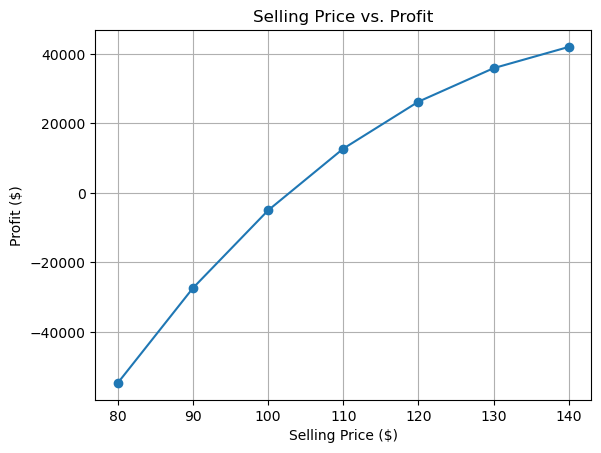

In [220]:
# Plot
plt.plot(mt_dt1_df['selling_price'], mt_dt1_df['profit'], marker='o')

# Labeling the plot
plt.title('Selling Price vs. Profit')
plt.xlabel('Selling Price ($)')
plt.ylabel('Profit ($)')

# Show plot
plt.grid(True)
plt.show()

**It is non-linear with a curve, as the demand formula is quadratic**

### Using goal_seek

In [234]:
def goal_seek(model, obj_fn, target, by_changing, a, b, N=100, verbose=False):
    '''Approximate solution of f(x)=0 on interval [a,b] by bisection method.

    Parameters
    ----------
    model : object
        User defined object containing the appropriate methods and properties for doing the desired goal seek
    obj_fn : function
        The function for which we are trying to approximate a solution f(x)=target.
    target : float
        The goal
    by_changing : string
        Name of the input variable in model
    a,b : numbers
        The interval in which to search for a solution. The function returns
        None if (f(a) - target) * (f(b) - target) >= 0 since a solution is not guaranteed.
    N : (positive) integer
        The number of iterations to implement.
    verbose : boolean (default=False)
        If True, root finding progress is reported

    Returns
    -------
    x_N : number
        The midpoint of the Nth interval computed by the bisection method. The
        initial interval [a_0,b_0] is given by [a,b]. If f(m_n) - target == 0 for some
        midpoint m_n = (a_n + b_n)/2, then the function returns this solution.
        If all signs of values f(a_n), f(b_n) and f(m_n) are the same at any
        iteration, the bisection method fails and return None.
    '''
    # TODO: Checking of inputs and outputs
    
    # Clone the model
    model_clone = copy.deepcopy(model)
    
    # The following bisection search is a direct adaptation of
    # https://www.math.ubc.ca/~pwalls/math-python/roots-optimization/bisection/
    # The changes include needing to use an object method instead of a global function
    # and the inclusion of a non-zero target value.
    
    setattr(model_clone, by_changing, a)
    f_a_0 = getattr(model_clone, obj_fn)()
    setattr(model_clone, by_changing, b)
    f_b_0 = getattr(model_clone, obj_fn)()
    
    if (f_a_0 - target) * (f_b_0 - target) >= 0:
        # print("Bisection method fails.")
        return None
    
    # Initialize the end points
    a_n = a
    b_n = b
    for n in range(1, N+1):
        # Compute the midpoint
        m_n = (a_n + b_n)/2
        
        # Function value at midpoint
        setattr(model_clone, by_changing, m_n)
        f_m_n = getattr(model_clone, obj_fn)()
        
        # Function value at a_n
        setattr(model_clone, by_changing, a_n)
        f_a_n = getattr(model_clone, obj_fn)()
        
        # Function value at b_n
        setattr(model_clone, by_changing, b_n)
        f_b_n = getattr(model_clone, obj_fn)()
        
        if verbose:
            print(f"n = {n}, a_n = {a_n}, b_n = {b_n}, m_n = {m_n}, width = {b_n - a_n}")

        # Figure out which half the root is in, or if we hit it exactly, or if the search failed
        if (f_a_n - target) * (f_m_n - target) < 0:
            a_n = a_n
            b_n = m_n
            if verbose:
                print("Root is in left half")
        elif (f_b_n - target) * (f_m_n - target) < 0:
            a_n = m_n
            b_n = b_n
            if verbose:
                print("Root is in right half")
        elif f_m_n == target:
            if verbose:
                print("Found exact solution.")
            return m_n
        else:
            if verbose:
                print("Bisection method fails.")
            return None
    
    # If we get here we hit iteration limit, return best solution found so far
    if verbose:
        print("Reached iteration limit")
    return (a_n + b_n)/2

In [238]:
goal_seek(model_test, 'profit', 0, 'selling_price', 80, 140, N=100, verbose=True)

n = 1, a_n = 80, b_n = 140, m_n = 110.0, width = 60
Root is in left half
n = 2, a_n = 80, b_n = 110.0, m_n = 95.0, width = 30.0
Root is in right half
n = 3, a_n = 95.0, b_n = 110.0, m_n = 102.5, width = 15.0
Root is in right half
n = 4, a_n = 102.5, b_n = 110.0, m_n = 106.25, width = 7.5
Root is in left half
n = 5, a_n = 102.5, b_n = 106.25, m_n = 104.375, width = 3.75
Root is in left half
n = 6, a_n = 102.5, b_n = 104.375, m_n = 103.4375, width = 1.875
Root is in left half
n = 7, a_n = 102.5, b_n = 103.4375, m_n = 102.96875, width = 0.9375
Root is in left half
n = 8, a_n = 102.5, b_n = 102.96875, m_n = 102.734375, width = 0.46875
Root is in left half
n = 9, a_n = 102.5, b_n = 102.734375, m_n = 102.6171875, width = 0.234375
Root is in left half
n = 10, a_n = 102.5, b_n = 102.6171875, m_n = 102.55859375, width = 0.1171875
Root is in right half
n = 11, a_n = 102.55859375, b_n = 102.6171875, m_n = 102.587890625, width = 0.05859375
Root is in left half
n = 12, a_n = 102.55859375, b_n = 102

102.57578606424767

**The breakeven selling price is $102.58**

### 2-Way Data Table

In [242]:
# Specify input ranges for scenarios (dictionary)
dt_param_ranges = {'selling_price': np.arange(80, 141, 10),
                  'var_cost': np.arange(85, 111, 5)}

# Specify desired outputs (list)
outputs = ['profit', 'total_cost']

# Use data_table function to create dataframe
mt_dt2_df = data_table(model_test, dt_param_ranges, outputs)
mt_dt2_df

,selling_price,var_cost,profit,total_cost
0,80,85,-17420.0,206140.0
1,80,90,-29840.0,218560.0
2,80,95,-42260.0,230980.0
3,80,100,-54680.0,243400.0
4,80,105,-67100.0,255820.0
5,80,110,-79520.0,268240.0
6,90,85,6180.0,185060.0
7,90,90,-5000.0,196240.0
8,90,95,-16180.0,207420.0
9,90,100,-27360.0,218600.0


C:\Users\ahojd\anaconda3\envs\aap\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


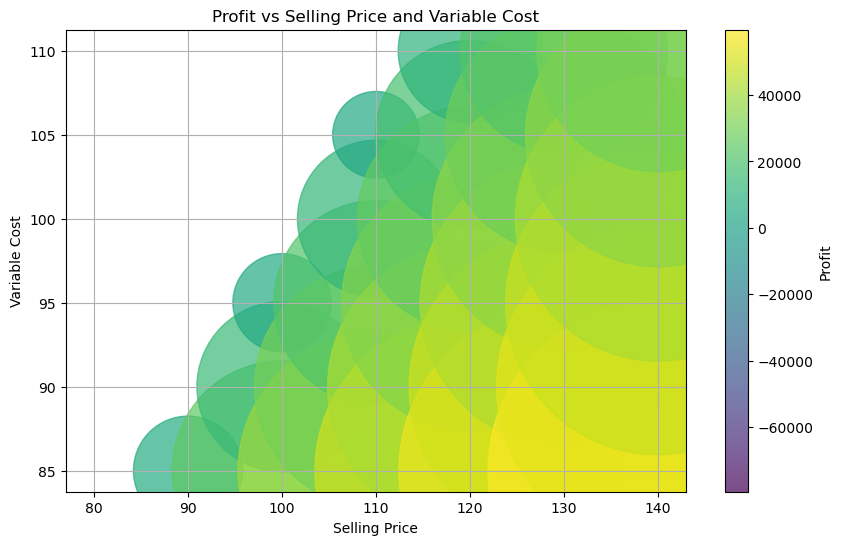

In [290]:
# Scatter plot - negatives caused an error
plt.figure(figsize=(10, 6))
plt.scatter(mt_dt2_df['selling_price'], mt_dt2_df['var_cost'], s=mt_dt2_df['profit'], c=mt_dt2_df['profit'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Profit')
plt.xlabel('Selling Price')
plt.ylabel('Variable Cost')
plt.title('Profit vs Selling Price and Variable Cost')
plt.grid(True)
plt.show()


***I love the visual of this plot - but I'll do something that is a little more readable***

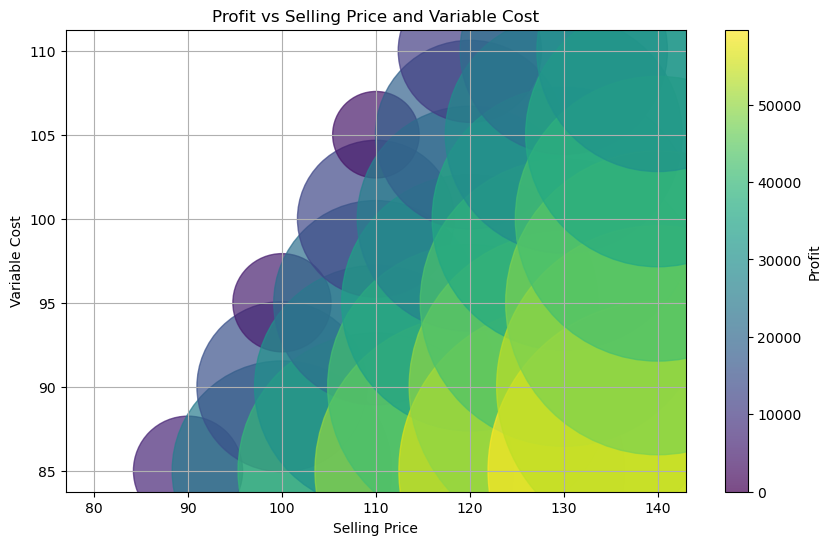

In [292]:
# Handling NaN and negative values in 'profit' column
mt_dt2_df['profit'] = mt_dt2_df['profit'].fillna(0)  # Fill NaN with 0
mt_dt2_df['profit'] = mt_dt2_df['profit'].clip(lower=0)  # Clip negative values to 0

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(mt_dt2_df['selling_price'], mt_dt2_df['var_cost'], s=mt_dt2_df['profit'], c=mt_dt2_df['profit'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Profit')
plt.xlabel('Selling Price')
plt.ylabel('Variable Cost')
plt.title('Profit vs Selling Price and Variable Cost')
plt.grid(True)
plt.show()

### Re-do goal_seek \\$80 - 250:
**I was able to get 227 to work, 228 - 250 failed - I changed N and that didn't help**  <br>
**It's the same breakeven $102.58**

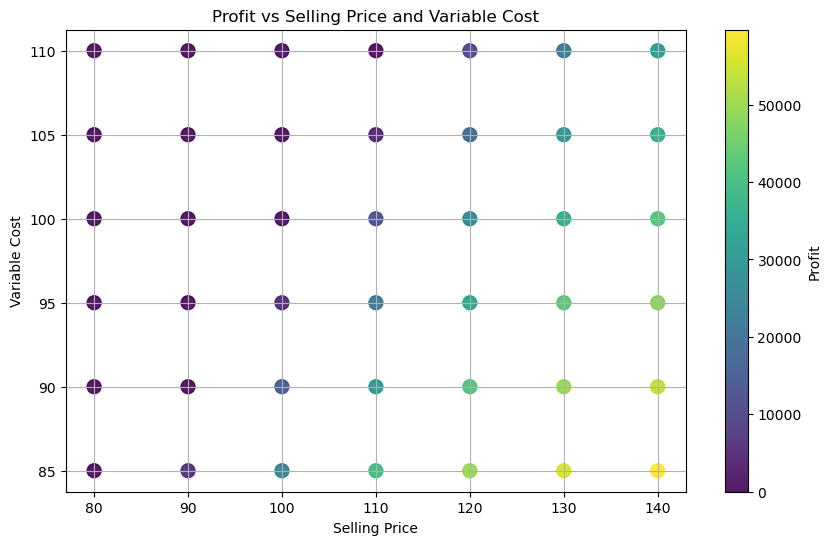

In [299]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(mt_dt2_df['selling_price'], mt_dt2_df['var_cost'], s=100, c=mt_dt2_df['profit'], cmap='viridis', alpha=0.9)
plt.colorbar(label='Profit')
plt.xlabel('Selling Price')
plt.ylabel('Variable Cost')
plt.title('Profit vs Selling Price and Variable Cost')
plt.grid(True)
plt.show()

***While I love the 'viridis' colors, one of my group project members from my last class is colorblind, there was supposed to be a 'colorblind' selection, but that caused an error, 'cividis' is supposed to be another good choice - I think it still depends on what colors the individual sees best***

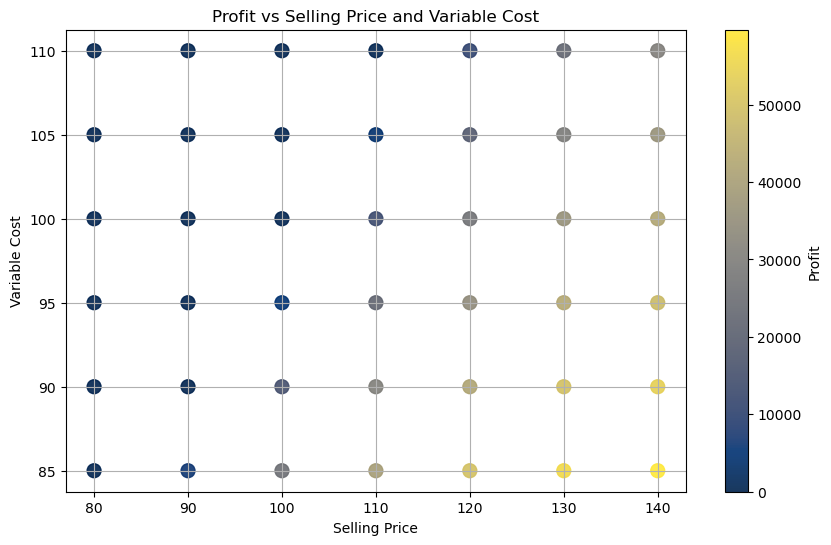

In [303]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(mt_dt2_df['selling_price'], mt_dt2_df['var_cost'], s=100, c=mt_dt2_df['profit'], cmap='cividis', alpha=0.9)
plt.colorbar(label='Profit')
plt.xlabel('Selling Price')
plt.ylabel('Variable Cost')
plt.title('Profit vs Selling Price and Variable Cost')
plt.grid(True)
plt.show()

In [274]:
goal_seek(model_test, 'profit', 0, 'selling_price', 80, 227, N=100, verbose=True)

n = 1, a_n = 80, b_n = 227, m_n = 153.5, width = 147
Root is in left half
n = 2, a_n = 80, b_n = 153.5, m_n = 116.75, width = 73.5
Root is in left half
n = 3, a_n = 80, b_n = 116.75, m_n = 98.375, width = 36.75
Root is in right half
n = 4, a_n = 98.375, b_n = 116.75, m_n = 107.5625, width = 18.375
Root is in left half
n = 5, a_n = 98.375, b_n = 107.5625, m_n = 102.96875, width = 9.1875
Root is in left half
n = 6, a_n = 98.375, b_n = 102.96875, m_n = 100.671875, width = 4.59375
Root is in right half
n = 7, a_n = 100.671875, b_n = 102.96875, m_n = 101.8203125, width = 2.296875
Root is in right half
n = 8, a_n = 101.8203125, b_n = 102.96875, m_n = 102.39453125, width = 1.1484375
Root is in right half
n = 9, a_n = 102.39453125, b_n = 102.96875, m_n = 102.681640625, width = 0.57421875
Root is in left half
n = 10, a_n = 102.39453125, b_n = 102.681640625, m_n = 102.5380859375, width = 0.287109375
Root is in right half
n = 11, a_n = 102.5380859375, b_n = 102.681640625, m_n = 102.60986328125, w

102.57578606424767

### Another 1-Way Data Table \\$80 - 250:

In [311]:
# Specify input ranges for scenarios (dictionary)
dt_param_ranges = {'selling_price': np.arange(80, 251, 10)}

# Specify desired outputs (list)
outputs = ['profit', 'demand']

# Use data_table function
mt_dt3_df = data_table(model_test, dt_param_ranges, outputs)
mt_dt3_df

,selling_price,profit,demand
0,80,-54680.0,2484.0
1,90,-27360.0,2236.0
2,100,-5000.0,2000.0
3,110,12760.0,1776.0
4,120,26280.0,1564.0
5,130,35920.0,1364.0
6,140,42040.0,1176.0
7,150,45000.0,1000.0
8,160,45160.0,836.0
9,170,42880.0,684.0


***LOL - oops...negatives!!! I hate it when that happens...***

### Simulation